# Figure S2: Influence of parameter choice on the phase diagram

To study to what extend the phase diagram depends on the cost of infection $c_{\rm inf}$, and on the trade-off shapes $c_{\rm def}(c_{\rm con}), c_{\rm uptake}(p_{\rm uptake})$ we plot the phase diagram for a number of different choices in the following.

Import packages.

In [1]:
from cycler import cycler
import sys
sys.path.append('../lib')
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib import transforms, gridspec, ticker
import palettable
import shapely.ops
%matplotlib inline
import plotting
import evolimmune
import misc
import analysis
%load_ext autoreload
%autoreload 2
plt.style.use(['paper'])
plt.rc('lines', linewidth=1.0)
plt.rc('axes', labelpad=1.0)
eps = 1e-8

use czrecursion, cztogrowthrate
use cstepmarkov


Read in and summarize data

In [2]:
df = analysis.loadnpz('data/phases.npz')
analysis.intelligent_describe(df, nunique=10)
dfg = df.groupby(['lambda_', 'mus', 'cup'])
nparams = len(dfg)

-----------------------------------------------------
values of columns with no more than 10 unique entries

boundary: ac; ap; cm; io; mi; pc; pi; pm; po
boundtol: 0.005
cup: 0.1*pup+pup**2; 0.05*pup+2*pup**2; 0.2*pup+2*pup**2
deltainit: 0.02
deltatol: 0.0005
lambda_: 1.5; 3.0; 4.5
logfeps: -9.0
mus: 0.5*(1.0-2.0*epsilon/(1.0+epsilon)), 0.5*(1.0+0.8*epsilon); 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon; 1.0-epsilon, 1.4-0.6*(1.0-epsilon)+0.2*(1.0-epsilon)**2; 1.5*(1.0-2.0*epsilon/(1.0+epsilon)), 1.5*(1.0+0.8*epsilon)
nburnin: 10000.0
niter: 1000000.0
qboundtol: 0.0005
xtol: 0.025
xtolbound: 0.01
-----------------------------------------------------
summary statistics of other columns

              aenv     pienvbnd
count  1005.000000  1005.000000
mean      0.500825     0.555374
std       0.353774     0.289091
min       0.000015    -0.408107
25%       0.133078     0.373598
50%       0.523847     0.575282
75%       0.855588     0.769385
max       0.951229     1.003422
---------------

define colors used in plot and phasenames

In [3]:
black = matplotlib.rcParams['text.color']
colors = np.asarray(palettable.colorbrewer.qualitative.Set3_6.mpl_colors)[[4, 0, 2, 3, 5, 1]]
strategies_s = ['a', 'p', 'o', 'i', 'm', 'c']
color_dict = dict(zip(strategies_s, colors))
linecolors = palettable.colorbrewer.qualitative.Dark2_6.mpl_colors
plt.rc('axes', prop_cycle=cycler('color', linecolors))
phasenames = misc.DefaultIdentityDict(o='$i$', i='$ib$')

Define plotting functions

In [4]:
def plotmus(ax, musstr, alpha=1.0, label=True):
    epsilon = np.linspace(0.0, 1.0, 100)
    mus = evolimmune.mus_from_str(musstr)
    mu1, mu2 = mus(epsilon)
    if label:
        ax.plot(mu1, mu2, c=linecolors[1], alpha=alpha, label='defense')
    else:
        ax.plot(mu1, mu2, c=linecolors[1], alpha=alpha)
    ax.plot(mu1[0], mu2[0], 'o', markeredgecolor='none', markersize=3, c=linecolors[1], alpha=alpha)
    
def plotstatecosts(ax, musstr, musstrref=None, lambda_=None):
    if lambda_:
        ax.text(1, 1, '${0}={1}$'.format(r'c_{\rm inf}', lambda_),
               transform=ax.transAxes, ha='right', va='top')
    if musstrref is not None:
        plotmus(ax, musstrref, alpha=0.25, label=False)
    plotmus(ax, musstr)
    ax.set_xlabel(evolimmune.varname_to_tex['cconstitutive'])
    ax.set_ylabel(evolimmune.varname_to_tex['cdefense'])
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 2.7)
    ax.locator_params(nbins=3)

def plotcup(ax, cupstr, cupstrref=None):
    pup = np.linspace(0.0, 0.2, 100)
    if cupstrref is not None:
        cup = evolimmune.cup_from_str(cupstrref)
        ax.plot(pup, cup(pup), c=linecolors[2], alpha=.25)
    cup = evolimmune.cup_from_str(cupstr)
    ax.plot(pup, cup(pup), c=linecolors[2])
    ax.set_xlabel(evolimmune.varname_to_tex['pup'])
    ax.set_ylabel(evolimmune.varname_to_tex['cup'])
    ax.set_ylim(0, 0.1)
    ax.locator_params(nbins=1)

Putting it all together into one figure

3.0 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon 0.1*pup+pup**2
3.0 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon 0.2*pup+2*pup**2
3.0 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon 0.05*pup+2*pup**2
1.5 0.5*(1.0-2.0*epsilon/(1.0+epsilon)), 0.5*(1.0+0.8*epsilon) 0.1*pup+pup**2
4.5 1.5*(1.0-2.0*epsilon/(1.0+epsilon)), 1.5*(1.0+0.8*epsilon) 0.1*pup+pup**2
4.5 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon 0.1*pup+pup**2
3.0 0.5*(1.0-2.0*epsilon/(1.0+epsilon)), 0.5*(1.0+0.8*epsilon) 0.1*pup+pup**2
3.0 1.0-epsilon, 1.4-0.6*(1.0-epsilon)+0.2*(1.0-epsilon)**2 0.1*pup+pup**2


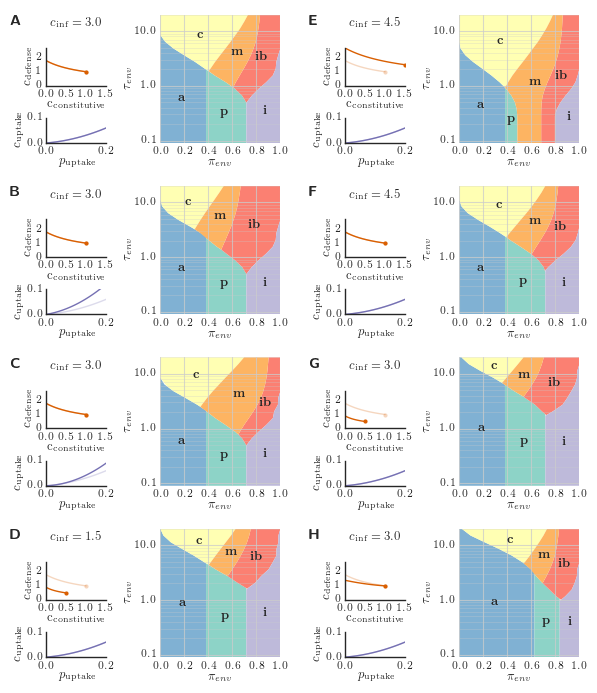

In [5]:
fig = plt.figure(figsize=(6, 7))
nrow = 4
nsubrow = 3
height_ratios = [1, 10, 10]
gsglobal = gridspec.GridSpec(4, 2)
import param1
lambdaref, musref, cupref = param1.lambda_, param1.mus, param1.cup
label_axes = []
for i in range(1, 9):
    p = __import__('param{}'.format(i))
    lambda_ = p.lambda_
    mus = p.mus
    cup = p.cup
    dfg = df[(df.mus==mus)&(df.cup==cup)&(df.lambda_==lambda_)]
    print lambda_, mus, cup
    gs = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gsglobal[(i-1)%nrow, (i-1)//nrow],
                                          width_ratios=[1, 2], height_ratios=[1, 30, 20],
                                          hspace=1.5, wspace=0.6)
    axlambda = fig.add_subplot(gs[0, 0])
    axlambda.text(0.5, -3.0, '${0}={1}$'.format(r'c_{\rm inf}', lambda_),
               transform=axlambda.transAxes, ha='center', va='top')
    axlambda.axis('off')
    axmu = fig.add_subplot(gs[1, 0])
    plotstatecosts(axmu, mus, musref)
    axcup = fig.add_subplot(gs[2, 0])
    plotcup(axcup, cup, cupref)
    for ax in [axmu, axcup]:
        plotting.despine(ax)
    axm = fig.add_subplot(gs[:, 1])
    try:
        polygons = evolimmune.polygons_from_boundaries(dfg, yconv=evolimmune.to_tau)
        phases = evolimmune.phases_from_polygons(polygons)
    except:
        pass
    else:
        for phasename, phase in phases.iteritems():
            try:
                axm.add_patch(analysis.shapely_to_mpl(phase, ec='None',
                                                      fc=color_dict[phasename],
                                                      lw=1.0)) 
                phaset = shapely.ops.transform(lambda x, y, z=None: (x, np.log(y+eps)), phase)
                axm.text(phaset.centroid.x, np.exp(phaset.centroid.y),
                         r'$\mathbf{%s}$'%phasenames[phasename][1:-1],
                         ha='center', va='center')
            except:
                pass


    axm.set_ylim(evolimmune.to_tau(df.aenv.min()), evolimmune.to_tau(df.aenv.max()))
    axm.set_yscale('log')
    axm.yaxis.set_major_formatter(ticker.ScalarFormatter())
    axm.set_xlabel('$\pi_{env}$')
    axm.set_ylabel(r'$\tau_{env}$')
    axm.grid(which='major', alpha=0.75)
    axm.grid(which='minor', lw=0.4, alpha=0.5)
    axm.set_axisbelow(False)
    plotting.despine(axm, spines='all')
    label_axes.append((i, axlambda))
label_axes = [ax for i, ax in sorted(label_axes)]
plotting.label_axes(label_axes, xy=(-0.6, 1.0), fontsize='large', va='top')
gsglobal.tight_layout(fig, h_pad=1.0, w_pad=2.0)
fig.savefig('SIaltphases.pdf')
fig.savefig('SIaltphases.svg')

**Influence of parameter choice on the phase diagram presented in Fig. 2.**
For every panel the parameter choices are shown on the left and the phase boundaries between **p**roto-adaptive, **i**nnate, **i**nnate **b**et hedging, **m**ixed and **C**RISPR-like strategies are shown on the right. As a reference, lines in lighter color show trade-off and uptake cost for parameter set used in Fig. 2.
**(A)** Phase diagram for parameters used in Fig. 2.
**(B)** More expensive active acquisition ($c_{\rm uptake}$ multiplied by a factor of two).
**(C)** Different functional form for cost of active acqusition: $c_{\rm uptake} = 0.05 \times p_{\rm uptake} + 2 \times p_{\rm uptake}^2$.
**(D)** More permissive state-dependent costs (costs multiplied by a factor of 0.5).
**(E)** Less permissive state-dependent costs (costs multiplied by a factor of 1.5).
**(F)** Higher cost of infection.
**(G)** Higher cost of immune protection.
**(H)** Different functional form for cost trade-off, $c_{\rm defense} = 1.4-0.6\times c_{\rm constitutive}+0.2 \times c_{\rm constitutive}^2$